## Item Similarity-based Collaborative Filtering Model

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation, linear_model
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn import datasets
import random
import time
import pylab as pl
import psycopg2

In [32]:
from lib.itemsimilarityclasscopy import item_similarity_recommender_py
from lib.precisionrecallcopy import remove_percentage, precision_recall_calculator, plot_precision_recall

In [ ]:
#Get deployed data from Heroku Postgres
import os

DATABASE_URL = os.environ['DATABASE_URL']

conn = psycopg2.connect(DATABASE_URL, sslmode='require')

# Read data from the database using a SQL query
df = pd.read_sql_query("SELECT * FROM user_track_df LIMIT 100000", conn)

# Don't forget to close the connection when you're done
conn.close()


In [33]:
df.head()

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,...,-8.176,0,0.0327,0.11900,0.000412,0.103,0.0396,126.051,4,4ssUf5gLb1GBLxi1BhPrVt
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,...,-12.640,1,0.0355,0.46800,0.000043,0.117,0.4430,122.012,4,3GBPw9NK25X1Wt2OUvOwY3
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEWFWM12A8C1308BA,1,TRLQPQJ128F42AA94F,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,...,-12.321,0,0.0653,0.29700,0.000267,0.127,0.9050,114.656,4,3jc496ljiyrS3ECrD7QiqL


In [34]:
#only taking 500000 rows for the sake of memory and time
similarity_df = df.head(10000)
similarity_df

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,...,-8.176,0,0.0327,0.119000,0.000412,0.1030,0.0396,126.051,4,4ssUf5gLb1GBLxi1BhPrVt
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.005640,0.000000,0.4080,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.005640,0.000000,0.4080,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,...,-12.640,1,0.0355,0.468000,0.000043,0.1170,0.4430,122.012,4,3GBPw9NK25X1Wt2OUvOwY3
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEWFWM12A8C1308BA,1,TRLQPQJ128F42AA94F,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,...,-12.321,0,0.0653,0.297000,0.000267,0.1270,0.9050,114.656,4,3jc496ljiyrS3ECrD7QiqL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4d8014f71ac81811ede984330be78b1717a1c46c,SOGETEU12A8C1410AA,1,TRESAAR128F932A45D,Madcon,Beggin',4YeKAwFn69ehnciOfi7Sbf,63,218707,0,...,-4.889,0,0.0534,0.028400,0.000000,0.0658,0.4310,129.040,4,6c4sUNBgdonFJz8Kx2VsGz
9996,4d8014f71ac81811ede984330be78b1717a1c46c,SOLLNTU12A6701CFDC,1,TRHTCXG12903CC2F60,3 Doors Down,Kryptonite,6ZOBP3NvffbU4SZcrnt1k6,80,233933,0,...,-5.708,0,0.0286,0.006640,0.000011,0.1680,0.5430,99.009,4,2RTUTCvo6onsAnheUk3aL9
9997,4d8014f71ac81811ede984330be78b1717a1c46c,SOLRGVL12A8C143BC3,1,TRRUVLO128F92DE6F7,La Roux,Bulletproof,3kMrazSvILsgcwtidZd1Qd,72,205733,0,...,-2.771,0,0.0477,0.000441,0.000065,0.0680,0.6820,123.016,4,3K2zB87GZv1krx031en5VA
9998,4d8014f71ac81811ede984330be78b1717a1c46c,SOOGANI12A8C139E6B,1,TRDVKSG128F933CA9C,Duffy,Stepping Stone,3g9nxeJPQM4CxhHt1iNlB4,51,209453,0,...,-6.407,0,0.0254,0.875000,0.000172,0.3520,0.4720,97.985,4,37NqXwtb6nIEqRt4EJSoIO


In [35]:
#splitting into train and test data
train_data_similarity, test_data_similarity = train_test_split(similarity_df, test_size = 0.20, random_state=0)

In [36]:
is_model = item_similarity_recommender_py()

In [37]:
is_model.create(train_data_similarity, 'user_id', 'song_id')

In [38]:
#Print the songs for the user in training data
user_id = df['user_id'][5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: b80344d063b5ccb3212f76538f3d9e43d87dca9e:
------------------------------------------------------------------------------------
SOTRSFZ12A8C142BF6
SOVHRGF12A8C13852F
SOOKGRB12A8C13CD66
SOJPFQG12A58A7833A
SONSAEZ12A8C138D7A
SOLUHPJ12A8C13AB0F
SOXSPON12A6D4F5DC2
SOBXHDL12A81C204C0
SORUFVF12AB018230B
SOEWFWM12A8C1308BA
SOJTEDZ12A58A7CB3D
SONRXOY12AB0181E84
SOSYBEV12AB0182933
SOFGUAY12AB017B0A8
SOBYHAJ12A6701BF1D
SOMSQJY12A8C138539
SORPMYJ12AF729EB90
SONVJAW12A8C139EFB
SOBSUJE12A6D4F8CF5
SOUKXIN12A8C133C7F
SOXZQDE12A8C135833
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 21
no. of unique songs in the training set: 3426
Non zero values in cooccurence_matrix :1486


,user_id,song_id,score,rank
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOMXQGH12A8C13CBEF,0.043651,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBTVDE12AF72A3DE5,0.041655,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOCUVSL12A8C140903,0.039683,3
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOJAMXH12A8C138D9B,0.036243,4
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOXFMZO12A6701D019,0.031746,5
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEOQLX12A8C1371D8,0.031746,6
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOLWFRS12A8AE48086,0.031746,7
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOPOAMI12A6D4FD786,0.031746,8
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPBDM12A8AE4804E,0.031746,9
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOVKECN12A6D4FD78B,0.031746,10


In [39]:
is_model.get_similar_items(['SOTWNDJ12A8C143984'])

no. of unique songs in the training set: 3426
Non zero values in cooccurence_matrix :402


,user_id,song_id,score,rank
0,,SODGVGW12AC9075A8D,0.254545,1
1,,SOTWSXL12A8C143349,0.237288,2
2,,SOUFPNI12A8C142D19,0.224490,3
3,,SONYKOW12AB01849C9,0.223684,4
4,,SOANQFY12AB0183239,0.212766,5
5,,SOGCWUH12AC90732B0,0.190476,6
6,,SOKLRPJ12A8C13C3FE,0.164384,7
7,,SOLRGVL12A8C143BC3,0.157895,8
8,,SOWEJXA12A6701C574,0.148936,9
9,,SOXWYZP12AF72A42A6,0.137255,10


In [40]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Call function to calculate precision and recall values
(ism_avg_precision_list, ism_avg_recall_list) = precision_recall_calculator(test_data_similarity.head(1000),
                                                                             train_data_similarity.head(1000), is_model, user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:297
Length of user sample:14
Getting recommendations for user:88196b0f0c0d76e819237dd2853024263e6e1631
No. of unique songs for the user: 42
no. of unique songs in the training set: 3426
Non zero values in cooccurence_matrix :5918
Getting recommendations for user:b81b63d5c1f33fa670b56c491566b4636d5767c9
No. of unique songs for the user: 6
no. of unique songs in the training set: 3426
Non zero values in cooccurence_matrix :224
Getting recommendations for user:3187e658fd71be99d68d96f3a61a436c8a607365
No. of unique songs for the user: 17
no. of unique songs in the training set: 3426
Non zero values in cooccurence_matrix :713
Getting recommendations for user:85e3419d1c9a24b532943283432b8bc08d9ff882
No. of unique songs for the user: 4
no. of unique songs in the training set: 3426
Non zero values in cooccurence_matrix :632
Getting recommendations for user:624d58f26c2e5691ed21bd560f8b3d30f932e9f7
No. of unique songs for the user: 4
no. of unique songs in the tr

Plotting precision recall curves.


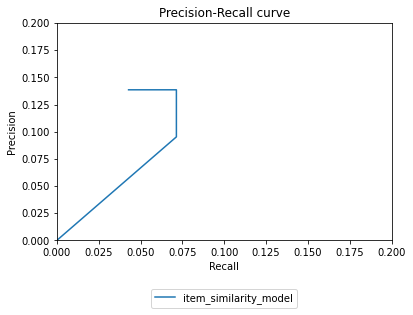

In [41]:
print("Plotting precision recall curves.")

plot_precision_recall(ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")